In [1]:
import psutil
from optmethods.first_order import RestNest
from proxskip.data import W8a_dataset

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pkl

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [3]:

num_cpus = psutil.cpu_count(logical=False)
print(num_cpus)

40


In [4]:
dataset = W8a_dataset(20)

Computing the smoothness constant via SVD, it may take a few minutes...
L: 0.661069029263127, l2: 6.61069029263127e-05


In [5]:

loss, x0,  _, _ = dataset.get_full_data()

# Nesterov's Method

  0%|          | 0/10000 [00:00<?, ?it/s]

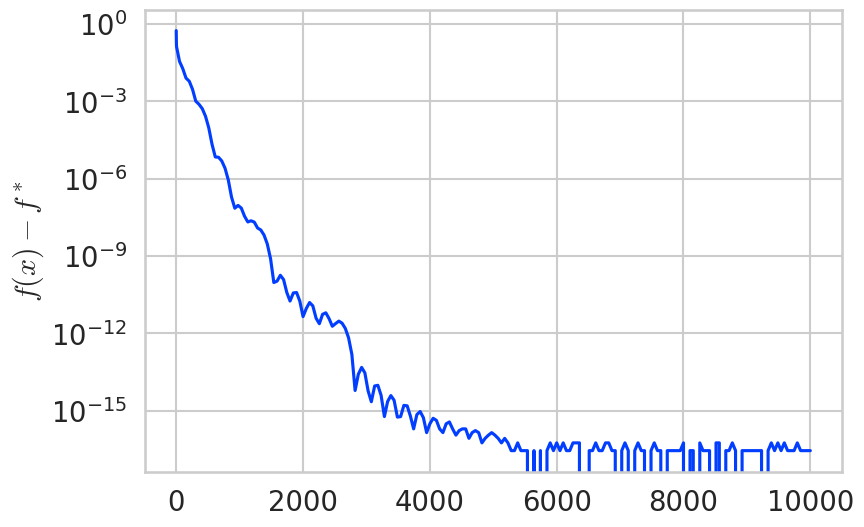

In [6]:

rest = RestNest(loss=loss, doubling=True)
rest_tr = rest.run(x0=x0, it_max=10000)
rest_tr.compute_loss_of_iterates()
rest.trace.plot_losses()

plt.yscale('log')

# Non-iid

In [7]:
losses = dataset.get_splitted_data(n_workers=20)
grad_norms = [np.linalg.norm(loss_i.gradient(loss.x_opt))**2 for loss_i in losses]
print(np.mean(grad_norms))

/usr/local/lib/python3.10/dist-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


0.002733343592131268


## Stohastic ProxSkip different M

In [8]:
from proxskip.methods.proxskip import ProxSkip

n_seeds = 1
batch_size = 2000

In [17]:
it_local = 100
skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
it_max = 2000
skip_decay_coef = dataset.l2 / 2

In [18]:
skip_results_M = []

for M in [1, 5, 10, 15, 20]:
    cohort_size = M
    n_workers = M
    losses = dataset.get_splitted_data(n_workers=M)

    skip_lr_max = skip_lr0
    skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
                lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
                it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
    skip.run(x0=x0, it_max=it_max)
    
    skip.trace.compute_loss_of_iterates()
    skip.terminate_workers()

    skip_results_M.append(skip.trace)

    with open('./data/skip_results_M.pkl', 'wb') as f:
        pkl.dump(skip_results_M, f)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
with open('./data/skip_results_M_.pkl', 'rb') as f:
    skip_results_M = pkl.load(f)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


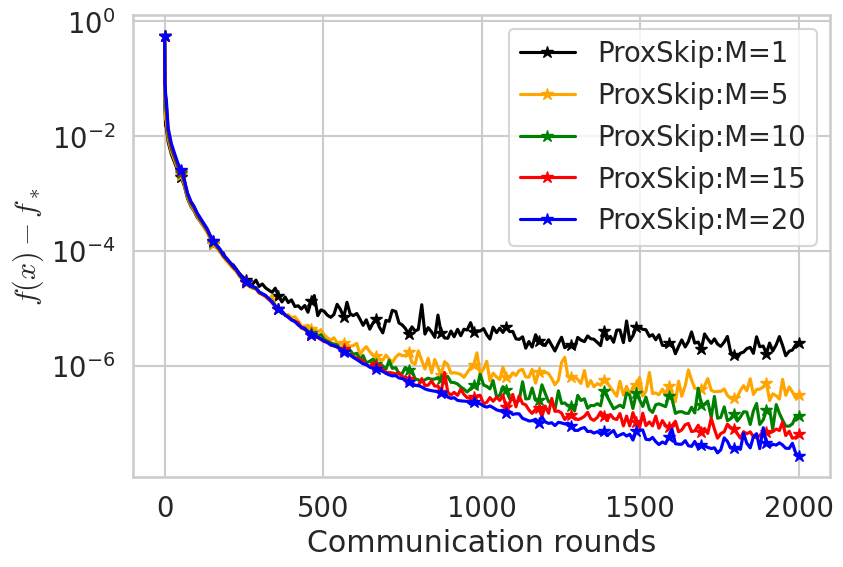

In [21]:
for m, result, c in zip([1, 5, 10, 15, 20], skip_results_M, ['k', 'orange', 'g', 'r', 'b']):
    result.plot_losses(label=f'ProxSkip:M={m}', marker='*', color=c)

plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.legend()
plt.savefig('linear_speedup.pdf')

In [25]:
n_seeds = 1
batch_size = 2000

In [26]:
it_local = 300
skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
it_max = 2000
skip_decay_coef = dataset.l2 / 2

In [27]:
skip_results_M = []

for M in [1, 5, 10, 15, 20]:
    cohort_size = M
    n_workers = M
    losses = dataset.get_splitted_data(n_workers=M)

    skip_lr_max = skip_lr0
    skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
                lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
                it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
    skip.run(x0=x0, it_max=it_max)
    
    skip.trace.compute_loss_of_iterates()
    skip.terminate_workers()

    skip_results_M.append(skip.trace)

    with open('./data/skip_results_M_300.pkl', 'wb') as f:
        pkl.dump(skip_results_M, f)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2023-12-21 12:40:40,765	WARNING worker.py:2074 -- WARNING: 36 PYTHON worker processes have been started on node: 302df200bed167423b35352f7524c363bf402905bdf9513e47473bac with address: 172.17.0.7. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


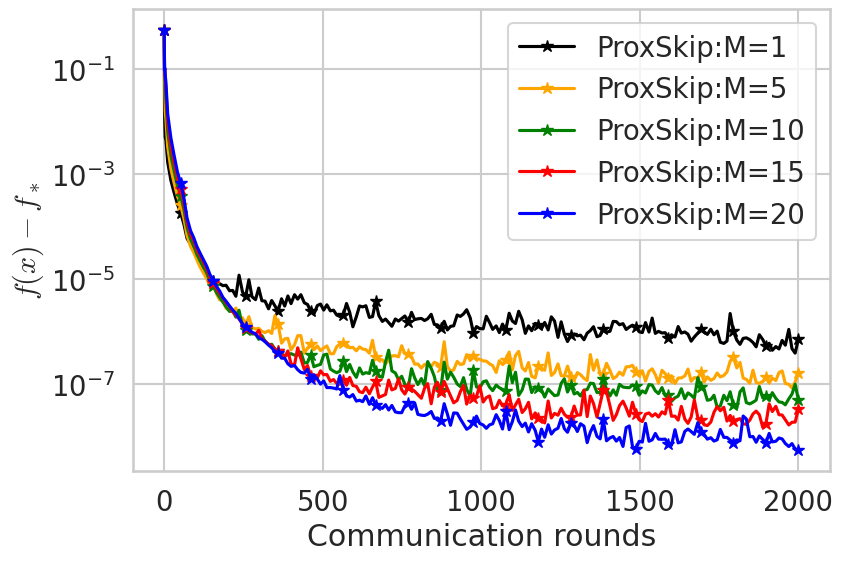

In [28]:
for m, result, c in zip([1, 5, 10, 15, 20], skip_results_M, ['k', 'orange', 'g', 'r', 'b']):
    result.plot_losses(label=f'ProxSkip:M={m}', marker='*', color=c)

plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.legend()
plt.savefig('linear_speedup.pdf')

## Non-Stohastic Proxskip different options of p

In [46]:
n_seeds = 1
batch_size = None

In [47]:
skip_lr0 = 1 / loss.smoothness 
it_max = 700
skip_decay_coef = dataset.l2 / 2

In [49]:
skip_results_p = []
M = 5
cohort_size = M
n_workers = M
losses = dataset.get_splitted_data(n_workers=M)

for it_local in [100, 200, 300, 500, 1000]:
    
    
    skip_lr_max = skip_lr0
    skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
                lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
                it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=it_local, iid=False, losses=losses)
    skip.run(x0=x0, it_max=it_max)
    
    skip.trace.compute_loss_of_iterates()
    skip.terminate_workers()

    skip_results_p.append(skip.trace)

    with open('./data/skip_results_p_.pkl', 'wb') as f:
        pkl.dump(skip_results_p, f)

  0%|          | 0/700 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


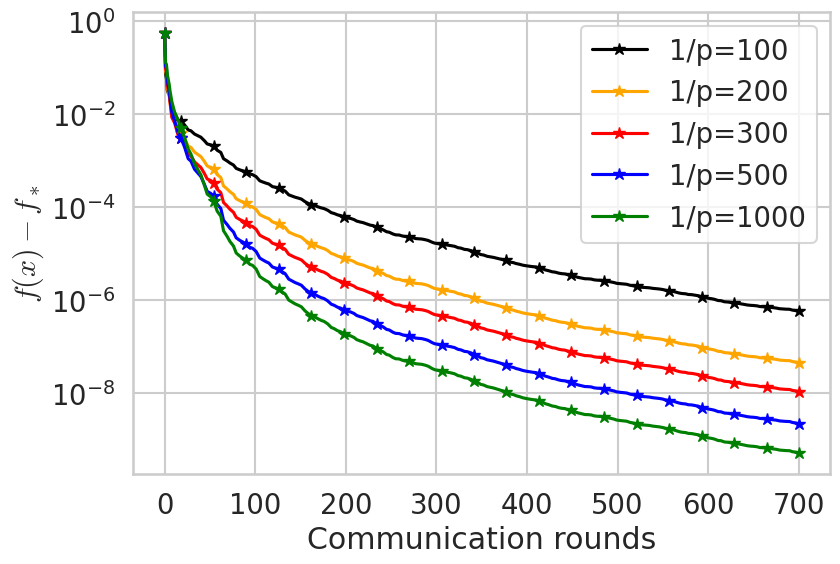

In [ ]:
for it_local, result, c in zip([100, 200, 300, 500, 1000], skip_results_p, ['k', 'orange', 'r', 'b', 'green']):
    result.plot_losses(label=f'1/p={it_local}', marker='*', color=c)

plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.legend()
# plt.savefig('linear_speedup.pdf')